# Sea ice segmentation using the IFT: Identifying bright sea ice regions

The k-means sea ice segmentation uses the false color image and the morphological residue. It 


 It produces a variety of grayscale and binary images. Along the way, I suspect some information is being lost. Sea ice classification is performed (at least implicitly) by the `get_ice_masks` function. This function uses two separate methods: one, a simple image binarization of the morphological residue, and two, a k-means clustering with a complicated series of threshold checks. This notebook examines these methods in detail.

## Preliminary work
Before we can run the segmentation, we need the morphological residue. The IFT preprocessing notebook demonstrates the method, however for this study we need the results on the validation dataset. Prior to running the notebook, run the script `ift_preprocess.jl`

## Analysis - Training Dataset
Note: Many of the training images are mostly cloud covered, and may not be suitable for ice floe segmentation. We may need to return to the image preprocessing steps, to see whether the tilewise histogram adjustment can provide views through the clouds in such cases. 
1. Is it correct that most of the detectable ice floes belong to a single k-means cluster?

In [ ]:
# Location of the test images
test_dir = joinpath("/Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/", "test")

using Pkg
# Specifying an environment makes it easier to work with package versions
Pkg.activate("calval")

using IceFloeTracker
using Images
using Random
using DataFrames
using CSV
using Plots
using StatsBase


In [604]:
function _SegmentedImage(image, image_indexmap)
    """Literally just what is in the ImageSegmentation library, I don't know why it
    doesn't work out of the box."""
    _segment_labels = Set(image_indexmap)
    _segment_labels = collect(_segment_labels)
    _segment_means = Dict{Int,float64(RGB)}()
    _segment_pixel_count = Dict{Int,Int}()
    
    for i in _segment_labels
        _segment_means[i] = zero(float64(RGB))
        _segment_pixel_count[i] = 0
    end
    
    for p in eachindex(image, image_indexmap)
        label = image_indexmap[p]
        _segment_means[label] += image[p]
        _segment_pixel_count[label] += 1
    end
    for i in _segment_labels
        _segment_means[i] /= _segment_pixel_count[i]
    end
    
    return SegmentedImage(image_indexmap, _segment_labels, _segment_means, _segment_pixel_count)
end

_SegmentedImage (generic function with 1 method)

In [635]:
"""Utility functions for viewing segmentation results"""
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end


tc_seg = _SegmentedImage(tc_image, label_components(segments))
fc_seg = _SegmentedImage(fc_image, label_components(segments))

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 5107

In [991]:
# Parameters

cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_upper=0.53
)

ice_masks_params = (
    band_7_threshold=5,
    band_2_threshold=230,
    band_1_threshold=240,
    band_7_threshold_relaxed=10,
    band_1_threshold_relaxed=190,
    possible_ice_threshold=75,
    k=4, # number of clusters for kmeans segmentation
    factor=255, # normalization factor to convert images to uint8
)

prelim_icemask_params = (radius=10, amount=2, factor=0.5)

(radius = 10, amount = 2, factor = 0.5)

In [ ]:
##### Example images are from the package folder
use_example_images = false
if use_example_images
    # Available test cases. Only showing Aqua truecolor for brevity. Each case has Aqua, Terra and has truecolor, falsecolor, and landmasks.
    example_loc = joinpath(test_dir, "test_inputs/preprocessing_workflows/")
    
    # Rearranged order just to make the figure prettier:
    case_names = ["sea_of_okhostk-50km-20180412", "barents_kara_seas-100km-20250507",  "baffin_bay-200km-20060704", 
        "greenland_sea-50km-20180712", "east_siberian_sea-100km-20190612",  "bering_chukchi_seas-200km-20210314", 
        "beaufort_sea-50km-20070614", "hudson_bay-100km-20060513",  "laptev_sea-200km-20230613"]
    
    # View the morphological residue files
    file_names = [split(c, "-")[3]*".250m.aqua.morphed_residue.tiff" for c in case_names]
    Images.mosaicview([RGB.(load(joinpath(example_loc, case, file)))
            for (case, file) in zip(case_names, file_names)], ncol=3)
end

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`


In [ ]:
if use_example_images
    case = "laptev_sea-200km-20230613"
    print(case)
    date = split(case, "-")[3]
    satellite = "aqua"
    
    lm_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "landmask.tiff"], ".")))))
    fc_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "falsecolor.tiff"], ".")))))
    tc_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "truecolor.tiff"], ".")))))
    morphed_image = float64.(Gray.(load(joinpath(example_loc, case, join([date, "250m", satellite, "morphed_residue.tiff"], ".")))))
end

In [679]:
use_validation_images = true
if use_validation_images
    df = DataFrame(CSV.File("../data/validation_dataset_testtrain_split.csv"));
    df_training = copy(df[df.training .&& (df.visible_floes .== "yes"),:]);
    nothing
end

In [893]:
# initialize columns for precision, recall
df_training[!, "init_precision"] .= 0.
df_training[!, "init_recall"] .= 0.
df_training[!, "kmeans_frac_mode"] .= 0.

if use_validation_images
    data_dir = "../../ice_floe_validation_dataset/data/"
    mr_dir = "../data/validation_dataset/morphological_residue/"
    for row_idx in range(1, size(df_training)[1])
        row = df_training[row_idx, :]
        case_number = lpad(row[:case_number], 3, "0")
        region = row[:region]
        satellite = row[:satellite]
        date = Dates.format(row[:start_date], "yyyymmdd")
        tc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "truecolor", "250m", "tiff"], ".")
        fc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "falsecolor", "250m", "tiff"], ".")
        lm_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "landmask", "250m", "tiff"], ".")
        cm_savename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "cloudmask", "250m", "tiff"], ".")
        mr_savename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "morphed_residue", "250m", "tiff"], ".")
        
        lb_filename = join([case_number, region, date, satellite, "binary_floes.png"], "-")
        
        print(region, " ", row[:satellite], " ", case_number, "\n")
    
        lm_image = float64.(RGB.(load(joinpath(data_dir, "modis", "landmask", lm_filename))))
        fc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "falsecolor", fc_filename))))
        tc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "truecolor", tc_filename))))
        lb_image = RGB.(load(joinpath(data_dir, "validation_dataset", "binary_floes", lb_filename)))
        
        morphed_image = float64.(Gray.(load(joinpath(mr_dir, mr_savename))))
        morphed_im_int = Array(Int64.(morphed_image .* 255));
    
        cloudmask = IceFloeTracker.create_cloudmask(fc_image; cloud_mask_settings...)
        fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)
        landmask = IceFloeTracker.create_landmask(lm_image)
    
        prelim_sizes = size(tc_image) .÷ 1
        tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)
    
        prelim_icemask, binarized_tiling = IceFloeTracker.get_ice_masks(
        n0f8.(fc_image), morphed_im_int, .!landmask.dilated, tiles, true; ice_masks_params...
        )
    
        man_labels = channelview(lb_image)[1,:,:] .> 0;
        n_true = sum(man_labels)
        n_pred = sum(prelim_icemask)
        n_intersect = sum(man_labels .&& prelim_icemask)
        
        df_training[row_idx, :init_precision] = n_intersect/n_pred
        df_training[row_idx, :init_recall] = n_intersect/n_true;

        segments = zeros(size(morphed_im_int))
        for tile in tiles
            segments[tile...] = IceFloeTracker.kmeans_segmentation(morphed_image[tile...], k=4)
        end

        # Find fraction of labeled pixels that are in the most common cluster
        if size(segments[man_labels])[1] > 0
            nmode = StatsBase.mode(segments[man_labels])
        else
            nmode = 0
        end
        
        df_training[row_idx, :kmeans_frac_mode] = round(StatsBase.mean(segments[man_labels] .== nmode), sigdigits=2)
    end
end

baffin_bay terra 001
baffin_bay terra 004
baffin_bay terra 005
baffin_bay aqua 005
baffin_bay terra 006
baffin_bay aqua 006
baffin_bay aqua 007
baffin_bay terra 007
baffin_bay aqua 009
baffin_bay aqua 010
baffin_bay aqua 011
baffin_bay terra 011
baffin_bay aqua 012
baffin_bay aqua 013
baffin_bay aqua 014
baffin_bay terra 014
baffin_bay aqua 015
baffin_bay terra 016
baffin_bay terra 017
baffin_bay terra 018
baffin_bay terra 019
baffin_bay aqua 019
baffin_bay aqua 021
barents_kara_seas terra 022
barents_kara_seas terra 023
barents_kara_seas terra 025
barents_kara_seas aqua 029
barents_kara_seas aqua 033
barents_kara_seas terra 033
barents_kara_seas terra 034
barents_kara_seas aqua 036
barents_kara_seas aqua 037
barents_kara_seas terra 037
barents_kara_seas terra 039
beaufort_sea aqua 043
beaufort_sea terra 043
beaufort_sea aqua 044
beaufort_sea aqua 046
beaufort_sea terra 047
beaufort_sea terra 048
beaufort_sea terra 049
beaufort_sea aqua 050
beaufort_sea terra 050
beaufort_sea aqua 051


# Performance of the initial binary ice mask
Precision vs recall for the binary ice floe mask. Precision is fairly low: we don't see anything higher than approximately 0.6. Recall can be fairly high though, there are cases with recall of 1.

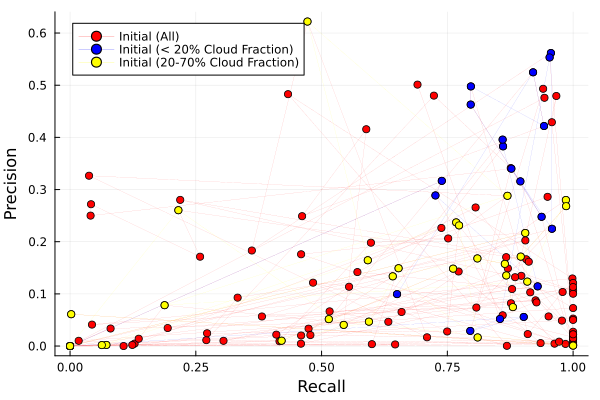

In [832]:
plot(df_training[:, :init_recall], df_training[:, :init_precision], label="Initial (All)",
    marker=:circle, color=:red, ylabel="Precision", xlabel="Recall", linewidth=0)

idx = df_training.cloud_fraction_manual .< 0.2
plot!(df_training[idx, :init_recall], df_training[idx, :init_precision], label="Initial (< 20% Cloud Fraction)",
    marker=:circle, color=:blue, ylabel="Precision", xlabel="Recall", linewidth=0)

idx = df_training.cloud_fraction_manual .> 0.2 .&& df_training.cloud_fraction_manual .< 0.7
plot!(df_training[idx, :init_recall], df_training[idx, :init_precision], label="Initial (20-70% Cloud Fraction)",
    marker=:circle, color=:yellow, ylabel="Precision", xlabel="Recall", linewidth=0)

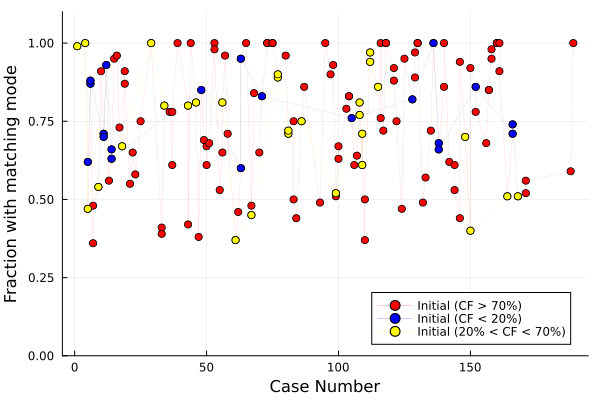

In [898]:
plot(df_training[:, :case_number], df_training[:, :kmeans_frac_mode], label="Initial (CF > 70%)",
    marker=:circle, color=:red, ylabel="Fraction with matching mode", xlabel="Case Number", linewidth=0)

idx = df_training.cloud_fraction_manual .< 0.2
plot!(df_training[idx, :case_number], df_training[idx, :kmeans_frac_mode], label="Initial (CF < 20%)",
    marker=:circle, color=:blue, ylabel="Fraction with matching mode", xlabel="Case Number", linewidth=0)

idx = df_training.cloud_fraction_manual .> 0.2 .&& df_training.cloud_fraction_manual .< 0.7
plot!(df_training[idx, :case_number], df_training[idx, :kmeans_frac_mode], label="Initial (20% < CF < 70%)",
    marker=:circle, color=:yellow, ylabel="Fraction with matching mode", xlabel="Case Number", linewidth=0, ylim=(0, 1.1))



# idx = df_training.cloud_fraction_manual .> 0.2 .&& df_training.cloud_fraction_manual .< 0.7
# plot!(df_training[idx, :init_recall], df_training[idx, :init_precision], label="Initial (20-70% Cloud Fraction)",
#     marker=:circle, color=:yellow, ylabel="Precision", xlabel="Recall", linewidth=0)

It is instructive to look at how the data quality appears for the cases where we have high recall and low precision. An initial look at some of the cases with ~1 recall were ones where the morphological residue was all 0s, and the ice_mask function called the entire image ice. This is likely an artifact of the choice in the n-labels functions to always return a k-means cluster, even if it has no connection to ice pixels. In total, 19 cases have recall over 0.5, which is all but one of the cases with low cloud cover.

In [899]:
df_training[idx .&& (df_training.kmeans_frac_mode .> 0.9), :] 

5×33 DataFrame
 Row │ Column1    case_number  region             start_date  center_lon  cent ⋯
     │ String15   Int64        String31           Date        Float64     Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 001_terra            1  baffin_bay         2022-09-11    -91.5275     7 ⋯
   2 │ 004_terra            4  baffin_bay         2019-09-25    -76.8094     7
   3 │ 029_aqua            29  barents_kara_seas  2014-07-08     49.7079     8
   4 │ 112_aqua           112  greenland_sea      2012-04-04    -13.4732     7
   5 │ 112_terra          112  greenland_sea      2012-04-04    -13.4732     7 ⋯
                                                              28 columns omitted

## Example case by row

In [992]:
# run example case
row = df[112 * 2, :]
case_number = lpad(row[:case_number], 3, "0")
region = row[:region]
satellite = row[:satellite]
date = Dates.format(row[:start_date], "yyyymmdd")
tc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "truecolor", "250m", "tiff"], ".")
fc_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "falsecolor", "250m", "tiff"], ".")
lm_filename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "landmask", "250m", "tiff"], ".")
cm_savename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "cloudmask", "250m", "tiff"], ".")
mr_savename = join([case_number, region, "100km", date], "-")*"."*join([satellite, "morphed_residue", "250m", "tiff"], ".")

lb_filename = join([case_number, region, date, satellite, "binary_floes.png"], "-")

print(region, " ", row[:satellite], " ", case_number, "\n")

lm_image = float64.(RGB.(load(joinpath(data_dir, "modis", "landmask", lm_filename))))
fc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "falsecolor", fc_filename))))
tc_image = float64.(RGB.(load(joinpath(data_dir, "modis", "truecolor", tc_filename))))
lb_image = RGB.(load(joinpath(data_dir, "validation_dataset", "binary_floes", lb_filename)))

morphed_image = float64.(Gray.(load(joinpath(mr_dir, mr_savename))))
morphed_im_int = Array(Int64.(morphed_image .* 255));

cloudmask = IceFloeTracker.create_cloudmask(fc_image; cloud_mask_settings...)
fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)
landmask = IceFloeTracker.create_landmask(lm_image)

prelim_sizes = size(tc_image) .÷ 1
tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)

prelim_icemask, binarized_tiling = IceFloeTracker.get_ice_masks(
n0f8.(fc_image), morphed_im_int, .!landmask.dilated, tiles, true; ice_masks_params...
)

man_labels = channelview(lb_image)[1,:,:] .> 0;
n_true = sum(man_labels)
n_pred = sum(prelim_icemask)
n_intersect = sum(man_labels .&& prelim_icemask)
# df_training[row_idx, :init_precision] = n_intersect/n_pred
# df_training[row_idx, :init_recall] = n_intersect/n_true;

greenland_sea terra 112


18186

In [993]:
n_intersect/n_pred, n_intersect/n_true

(0.48324608721069273, 0.942572820565979)

In [994]:
cloudmask = IceFloeTracker.create_cloudmask(fc_image; cloud_mask_settings...)
fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)
landmask = IceFloeTracker.create_landmask(lm_image)

(dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], non_dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1])

In [995]:
prelim_sizes = size(tc_image) .÷ 1
print(prelim_sizes)
tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1)

prelim_icemask, binarized_tiling = IceFloeTracker.get_ice_masks(
    n0f8.(fc_image), morphed_im_int, .!landmask.dilated, tiles, true; ice_masks_params...
)

(400, 400)

(icemask = Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], bin = Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

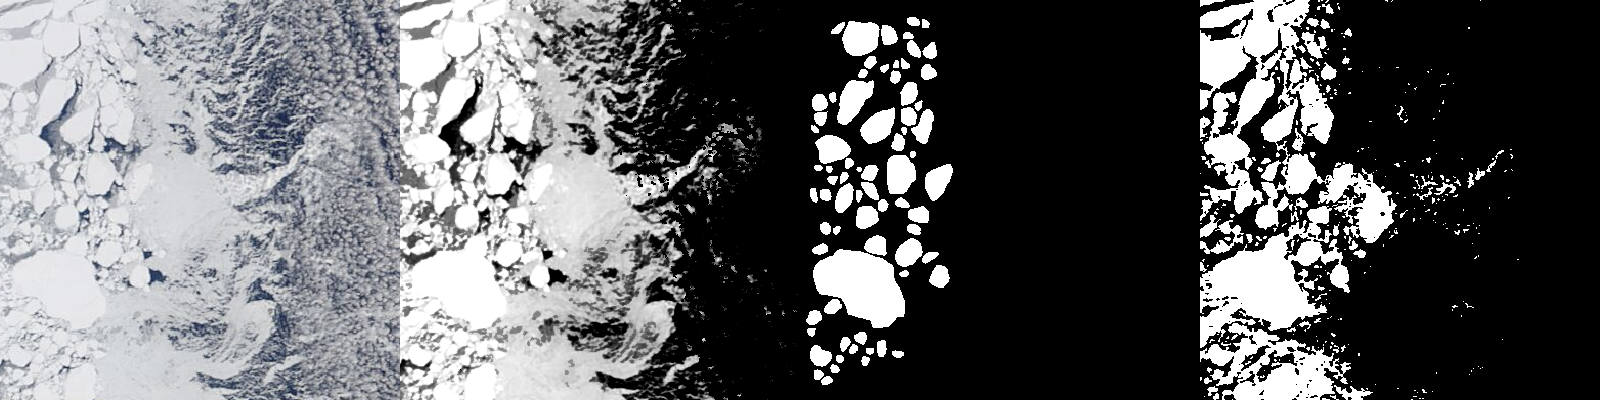

In [996]:
Images.mosaicview([tc_image, Gray.(morphed_image), Gray.(man_labels), Gray.(prelim_icemask)], nrow=1)

# Quality of the prelim icemask and binarized tiling
We can measure the performance of the default settings for the ice-mask and binarized tiling performance by computing the precision and recall, overall and object-by-object. For each image with at most 20% cloud cover, compute the prelim icemask and binarized tiling. Then, we can measure the performance directly as the percent agreement weighted by the number of true floe pixels and by the number of detected ice pixels.

In [997]:
man_labels = channelview(lb_image)[1,:,:] .> 0;

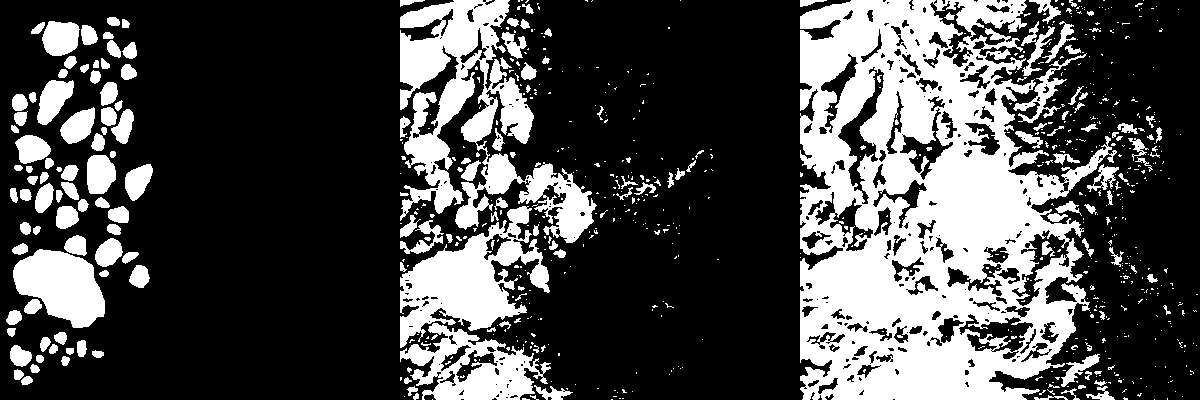

In [998]:
Images.mosaicview(Gray.(man_labels), Gray.(prelim_icemask), Gray.(binarized_tiling), nrow=1)

In [999]:
n_true = sum(man_labels)
n_pred = sum(prelim_icemask)
n_intersect = sum(man_labels .&& prelim_icemask)
P = n_intersect/n_pred
R = n_intersect/n_true
print(P, " ", R)

0.48324608721069273 0.942572820565979

Notes from looking at the 9 example cases. 

For the Beaufort Sea case, the result was okay but not ideal. For the Barents-Kara seas case, it worked really well with small tiles (one artifact).

Let's break down what has happened in this image so far. 
1. The image was broken into tiles, first. Here I've used 1-8 tiles, it's not clear what the ideal size is. Using 1 looks good usually, using 8 results in the bug where the prelim icemask flips some landmask pixels.
2. Then, the FC image, the morphological residue, the dilated landmask, etc were sent to the function `get_ice_masks()`, which is in the file `ice_masks.jl`.
3. Inside the `get_ice_masks` function, the following major steps occur on each tile:
   1. `kmeans_segmentation` with k=3 is applied to the morphological residue. Note here that the morphological residue is an integer matrix in the image input, then is transformed to Grayscale for kmeans segmentation. So the cast to integer may be unneeded.
   2. `get_nlabel` is called on the FC and the segmentation result to choose a single k-means cluster for sea ice
   3. Only this cluster is set to "True"
   4. Optionally, the imbinarize algorithm is also called on the adjusted morphological resiude.

# K-means segmentation
The function `kmeans_segmentation` is housed within the `segmentation_a_direct.jl` file. There are two methods:
1. `kmeans_segmentation(gray_image=Matrix{Gray{Float64}}, ice_labels=Vector{Int64}, k=4, max_iter=50`)
2. `kmeans_segmentation(gray_image=Matrix{Gray{Float64}}, k=4, maxiter=50)`
The K-means segmentation result divides the image into 4 classes. The IFT function attempts to make a binary mask based on the output of the K-means segmentation. So we ask the questions
- Do we typically see only one cluster representing all floes?

In [1021]:
segments = zeros(size(morphed_im_int))
for tile in tiles
    segments[tile...] = IceFloeTracker.kmeans_segmentation(morphed_image[tile...], k=4)
end

nmode = StatsBase.mode(segments[man_labels])
round(StatsBase.mean(segments[man_labels] .== nmode), sigdigits=2)

0.94

In [1022]:
for label in man_labeled.segment_labels
    idx = man_labeled.image_indexmap .== label
    n = man_labeled.segment_pixel_count[label]
    break
end

In [1023]:
man_labeled = _SegmentedImage(fc_image, label_components(lb_image))
fc_segments_k4 = _SegmentedImage(fc_image, Int64.(segments))
fc_segments = _SegmentedImage(fc_image, label_components(segments))

# Application of simple filter to assign all segments with area
# less than 1 km2 to a single class (label=0). 

min_area = 16
function size_filter(s, seg)
    seg.segment_pixel_count[s] > min_area && return s
    return 0
end

test = _SegmentedImage(fc_image, map(i->size_filter(i, fc_segments), labels_map(fc_segments)))

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 470

Top: True color image, True color manual label means
Bottom: Morphological residue, False color segment means

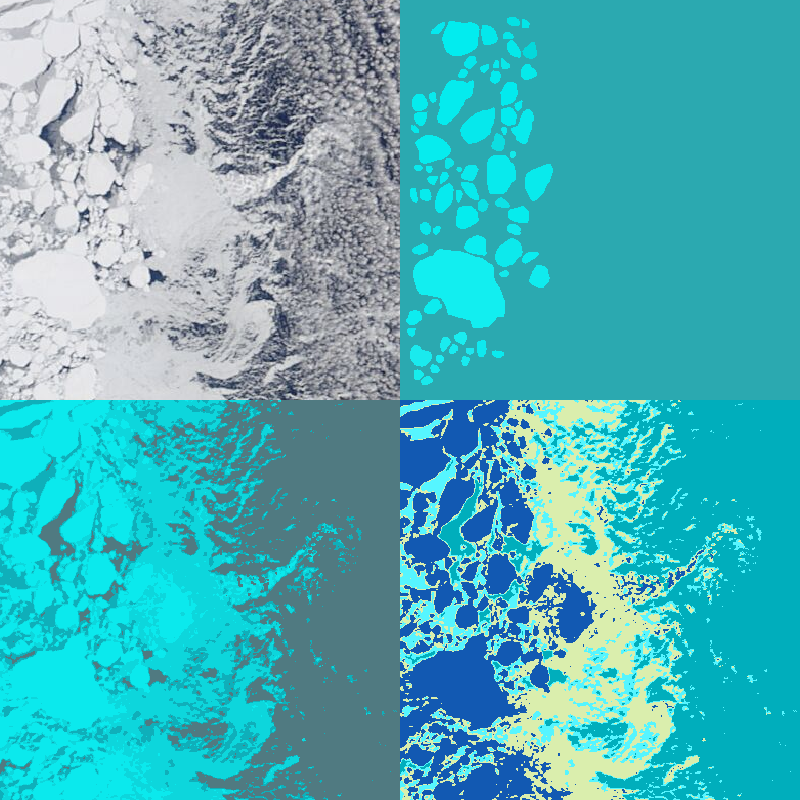

In [1024]:
print("Top: True color image, True color manual label means\n")
print("Bottom: Morphological residue, False color segment means")
Images.mosaicview(tc_image, view_seg(fc_segments_k4), # .* man_labels,
            view_seg(man_labeled), view_seg_random(fc_segments_k4), nrow=2)

* Boundary pixels often get added to a second category. Is it possible to find these edge pixes without dropping the rest?
* Multiplying by the traced shapes lets us see the number of ice floes given to a different category.

As a note, the segment means provide a convenient way to lookup the type classification for image regions for the sea ice label identification. 

What I'm seeing from this example is that the k-means result is actually doing really well at separating out the sea ice floes that we might be able to track from the background. We could enforce the minimum size here as a way to filter out the background from the ice floes. Later steps will help separate out the large floes.

There are methods for segment pruning, and segment merging that we can apply.

The next step is to see how the series of `get_ice_labels...` functions work (and whether they work).

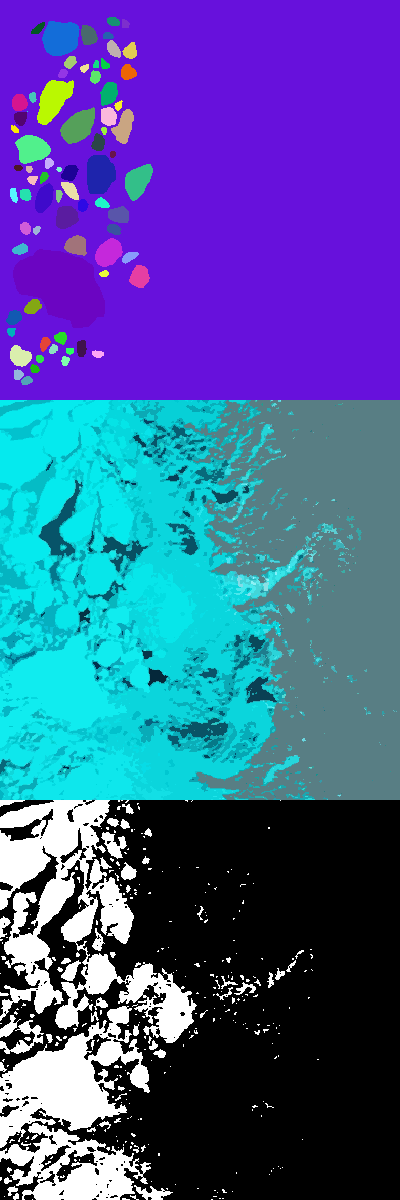

In [1025]:
zoom = (1:400, 1:400)
Images.mosaicview(view_seg_random(man_labeled)[zoom...], view_seg(fc_segments)[zoom...], Gray.(prelim_icemask)[zoom...],
    nrow=3)

Here's what's happening inside the tilewise floe labeling section.
1. Get the segment labels for that tile
2. Call the get_nlabel function, with the fc image, morphological residue, a "factor" to convert back to integers, and the 6 thresholds.
   1. Set the initial mask to pixels with $B_7 < 5$, $B_2 > 230$, and $B_1 > 240$.
   2. If any pixels satisfy all three, then select the k-means cluster with the most flagged pixels (Mode).
   3. Else, check if any pixels have $B_7 < 10$, $B_2 > 230$, and $B_1 > 190$.
   4. If any pixels satisfy all three, then select the k-means cluster with the most flagged pixels (Mode).
   5. Else, try the `get_nlabel_relaxation` function.
3. The `get_nlabel_relaxation` function starts by finding the image peaks for band 1 and band 2.
   1. If no peaks, return 1 !! This is a problem, because it allows non-floes and non-ice to be selected. It's okay to find nothing!
   2. Otherwise, use the identified peaks as thresholds for the same check as in step 2.1 and 2.3. !! Also a problem, because using the peak of the histogram results in losing data above the peak.
   3. If any are found, then return the mode.
   4. If none are found, then select just the ones that exceed the original band 2 threhold.
   5. If none are found, return 1.

I don't think that this threshold guess-and-check back-and-forth method is what we want to do. Really, the question is whether the object should be included in the binary floe mask image that will be sent to the morphological and watershed algorithms. It has the potential to provide bad data in many scenarios. 

What I'm thinking is that we need a more straightforward selection mechanism that separates the noisy background from the trackable floes. We can use the validation dataset to look at the statistics of mean floe brightness and check using segmentation metrics whether the number of k-means clusters is appropriate. We can expect some clusters to contain landfast ice, some to contain clouds, and others to have various types of sea ice floes.

## Calibration updates
- Ice thresholds: we can test the accuracy of this original mask. Can we go straight to the peaks and find tie points? Can we enforce physically reasonable band reflectance?
## Function updates (notes)
- get_ice_labels_mask. We can get rid of "factor" and use thresholds that already are scaled to 0 to 1.
- Can we simplify the processing without degrading the results? I find the tangle of segmentation steps confusing.

In [1026]:
t0, t1, t2 = prelim_icemask_params
test = IceFloeTracker.get_ice_labels_mask(n0f8.(fc_image), (60, 100, 100), 255);

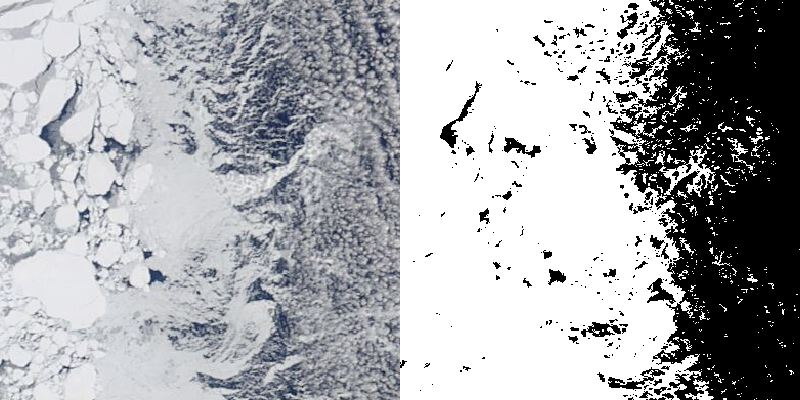

In [1027]:
Images.mosaicview(tc_image, Gray.(test), nrow=1)

In [1028]:
min_area = 16 # 1 km2
min_area = 64

# @time keep_segments = [x for x in keys(fc_seg.segment_pixel_count) if fc_seg.segment_pixel_count[x] >= min_area];

64

In [1029]:
# Application of simple filter to assign all segments with area
# less than 1 km2 to a single class (label=0). 
function size_filter(s, seg)
    seg.segment_pixel_count[s] > min_area && return s
    return 0
end

test = _SegmentedImage(fc_image, map(i->size_filter(i, fc_segments), labels_map(fc_segments)))

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 138

In [1030]:
# The segment means can then be used in a lookup table if needed, or some kind of plane partition.
segment_mean(test)

Dict{Int64, RGB{Float64}} with 138 entries:
  56   => RGB{Float64}(0.0577417,0.838945,0.855263)
  1703 => RGB{Float64}(0.0251377,0.91692,0.923111)
  1514 => RGB{Float64}(0.0195548,0.891468,0.902014)
  2616 => RGB{Float64}(0.290336,0.909629,0.928361)
  6    => RGB{Float64}(0.00694572,0.76092,0.809626)
  1419 => RGB{Float64}(0.0224395,0.905512,0.913231)
  2903 => RGB{Float64}(0.117342,0.485361,0.55435)
  45   => RGB{Float64}(0.020145,0.827182,0.866667)
  215  => RGB{Float64}(0.0406365,0.703723,0.744643)
  2324 => RGB{Float64}(0.0436735,0.663767,0.708472)
  846  => RGB{Float64}(0.0185897,0.686802,0.736765)
  2309 => RGB{Float64}(0.0687509,0.685836,0.717126)
  765  => RGB{Float64}(0.0252101,0.711373,0.770644)
  1695 => RGB{Float64}(0.0364672,0.652891,0.711312)
  262  => RGB{Float64}(0.0242128,0.650069,0.710032)
  865  => RGB{Float64}(0.0545944,0.848058,0.879892)
  2048 => RGB{Float64}(0.0317551,0.364323,0.444317)
  2079 => RGB{Float64}(0.0338049,0.670936,0.726185)
  567  => RGB{Float64}(0.

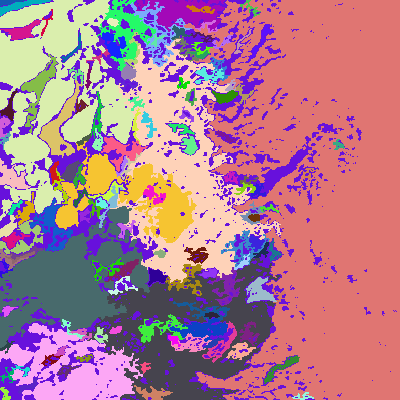

In [1031]:
rcolors = view_seg_random(test)
rcolors[zoom...]

In [1032]:
# rcolors[test.segment_labels == 0] .= RGB(0)

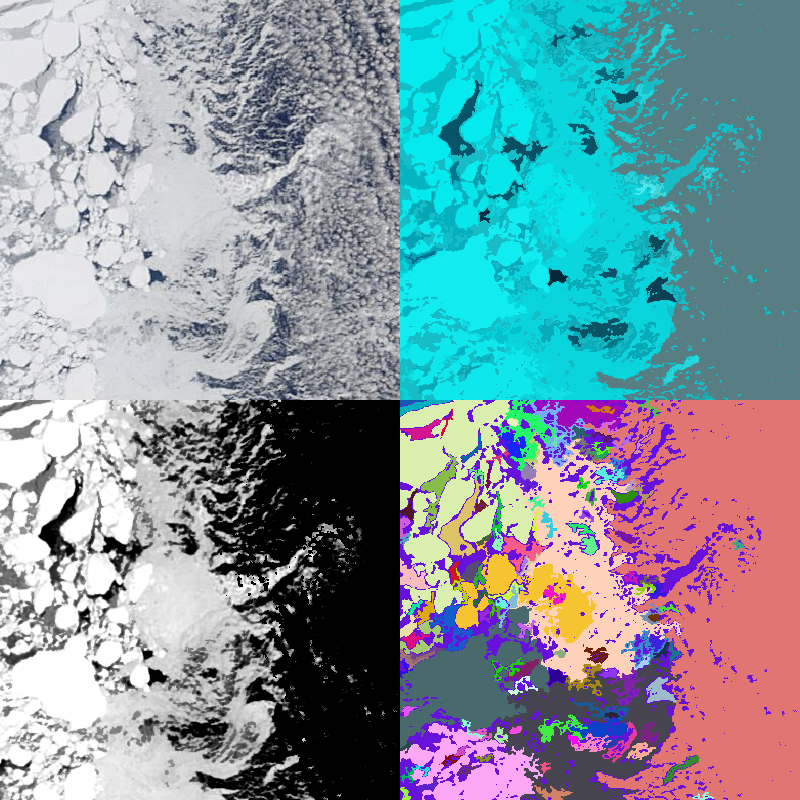

In [1033]:
Images.mosaicview(tc_image, morphed_image, view_seg(test), rcolors, nrow=2)

In [1034]:
sort(test.segment_pixel_count)

OrderedCollections.OrderedDict{Int64, Int64} with 138 entries:
  0   => 21366
  1   => 88
  2   => 274
  4   => 13094
  6   => 319
  10  => 177
  14  => 122
  15  => 70
  19  => 452
  39  => 193
  41  => 494
  42  => 142
  45  => 73
  47  => 9252
  50  => 70
  51  => 5543
  56  => 87
  59  => 80
  80  => 189
  85  => 79
  125 => 91
  161 => 77
  198 => 109
  215 => 69
  262 => 241
  ⋮   => ⋮

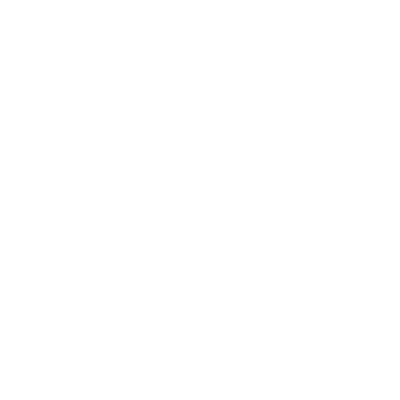

In [1035]:
bw = test.image_indexmap .!= 40
Images.mosaicview(Gray.(bw))

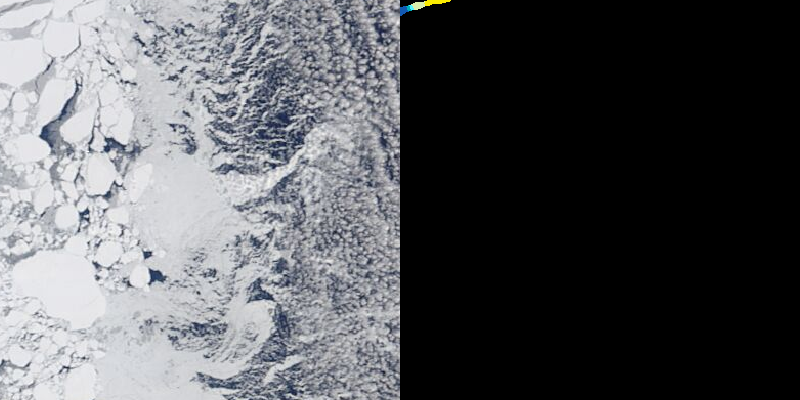

In [1036]:
using Images, ImageSegmentation

# img = load(download("http://docs.opencv.org/3.1.0/water_coins.jpg"));

# bw = Gray.(img) .> 0.5;

# dist = 1 .- distance_transform(feature_transform(bw));
bw = test.image_indexmap .!= 2
dist = 1 .- distance_transform(feature_transform(bw));
markers = label_components(dist .< -2);

wsegments = watershed(dist, markers)
Images.mosaicview(tc_image, map(i->get_random_color(i), labels_map(wsegments)) .* (1 .-bw), nrow=1)

# Watershed Segmentation of the Grayscale Image
"Ice floe segmentation is performed to minimize such identification errors by identifying intensity valleys and appplying a watershed semgmentation to each image. To this end, bordering ice-pixels are identified and connected via a awatershed function by calculating the inverse Euclidean distance of each ice-pixel to the nearest water-pixel, and recognizing that pixels within the center of the ice floes have larger absolute distances to water pixels than those at the contour. The watershed function is applied to both ice-water discriminated images and binary images that have already been processed via K-means color segmentation to reduce any artifacts due to incorrect segmentation."

segment_mask = ice_mask .&& tiled_binmask

```
function watershed1(bw::T) where {T<:Union{BitMatrix,AbstractMatrix{Bool}}}
    seg = -IceFloeTracker.bwdist(.!bw)
    mask2 = imextendedmin(seg)
    seg = impose_minima(seg, mask2)
    cc = label_components(imregionalmin(seg), trues(3, 3))
    w = ImageSegmentation.watershed(seg, cc)
    lmap = labels_map(w)
    return Images.isboundary(lmap) .> 0
end
```

The `watershed1` function operates on the binarized output of the K-means segmentation step. 
It uses a few `utils` functions that draw on Images and ImageSegmentation.

* `bwdist`: Wrapper for `Images.distance_transform(Images.feature_transform))`. Takes a boolean abstract array as an input. Location: `src/utils.jl`.
* `imextendedmin`: Wrapper for `ImageSegmentation.hmin_transform` and `Images.local_minima` with default depth threshold 2 and 8-neighborhood connectivity. Based on MATLAB's imextendedmin.
* `impose_minima`: Wrapper for `scikit-image.morphology.reconstruction` using the

What's happening inside the function: (1) The distance calculation is the distance of each pixel to a white pixel. So, a large distance is more likely to be the center of a floe. (2) imextendedmin finds connected components such that there is a constant value and all the boundaries have a higher value. The result is a set of markers that are within likely ice floes -- or at least, bright patches of ice.

Then, for the segmented result, what it does is

```
function get_segment_mask(ice_mask, tiled_binmask)
    for img in (ice_mask, tiled_binmask)
        fillholes!(img)
        img .= watershed1(img)
    end
    segment_mask = ice_mask .&& tiled_binmask
    return segment_mask
end
```

We fill the holes on the image, then apply watershed1 to each.

In [1037]:
im1 = deepcopy(prelim_icemask)
IceFloeTracker.fillholes!(im1)

seg = -IceFloeTracker.bwdist(.!im1)
_dist = Gray.(-seg ./ maximum(abs.(seg)))
mask2 = IceFloeTracker.imextendedmin(seg);
seg2 = IceFloeTracker.impose_minima(seg, mask2);
cc = label_components(IceFloeTracker.imregionalmin(seg2), trues(3, 3))
w = watershed(seg2, cc)
lmap = labels_map(w)
lmap_seg = _SegmentedImage(fc_image, lmap)

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 92

In [1038]:
im2 = deepcopy(binarized_tiling)
IceFloeTracker.fillholes!(im2)

seg = -IceFloeTracker.bwdist(.!im2)
_dist = Gray.(-seg ./ maximum(abs.(seg)))
mask2 = IceFloeTracker.imextendedmin(seg);
seg2 = IceFloeTracker.impose_minima(seg, mask2);
cc = label_components(IceFloeTracker.imregionalmin(seg2), trues(3, 3))
w = watershed(seg2, cc)
lmap2 = labels_map(w)
lmap_seg2 = _SegmentedImage(fc_image, lmap2)

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 119

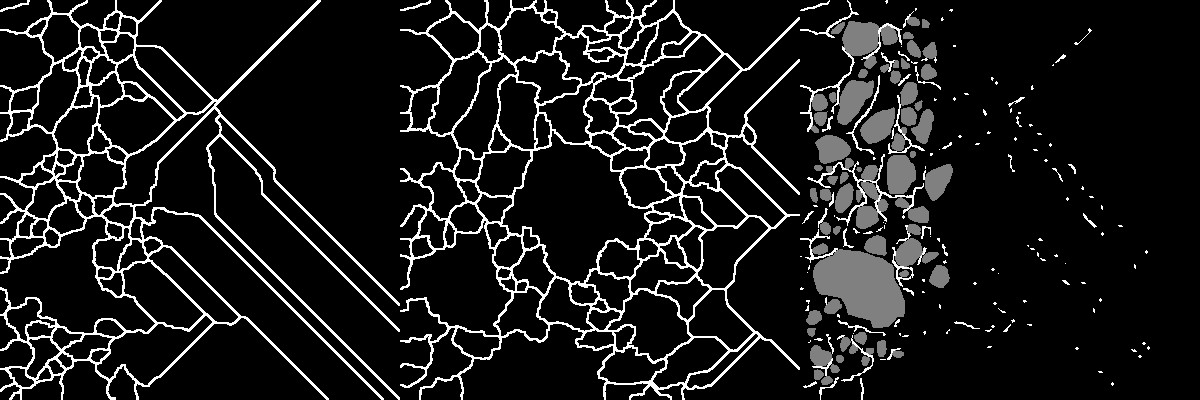

In [1039]:
Images.mosaicview(Gray.(Images.isboundary(lmap) .> 0), Gray.(Images.isboundary(lmap2) .> 0),
    Gray.((Images.isboundary(lmap2) .> 0) .&& (Images.isboundary(lmap) .> 0)) .+ 0.5 .* Gray.(man_labels),
    nrow=1)

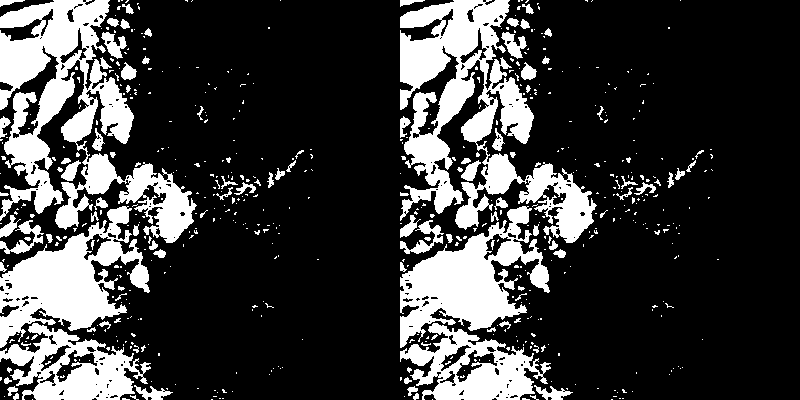

In [1040]:
Images.mosaicview(Gray.(prelim_icemask), Gray.(im1), nrow=1)

In [1041]:
outlines = man_labels .- Images.erode(man_labels);

Top left: Morphological residue, Top right: Preliminary Ice Mask
Bottom left: k-means result, Bottom right: watershed1 result

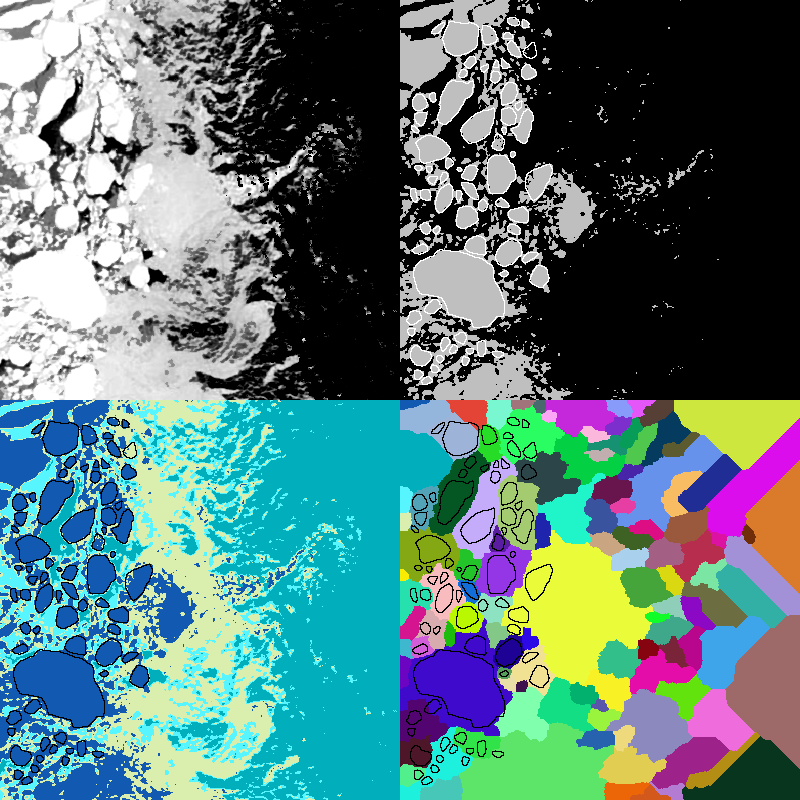

In [1042]:
print("Top left: Morphological residue, Top right: Preliminary Ice Mask\n")
print("Bottom left: k-means result, Bottom right: watershed1 result")
Images.mosaicview(morphed_image, view_seg_random(fc_segments_k4).* (1 .- outlines), 0.75 .* Gray.(prelim_icemask) .+ outlines,
    view_seg_random(lmap_seg2) .* (1 .- outlines), nrow=2)

The default watershed1 function does not work well on this image, at least. The regions are fairly random, and don't separate the bright colors well. 

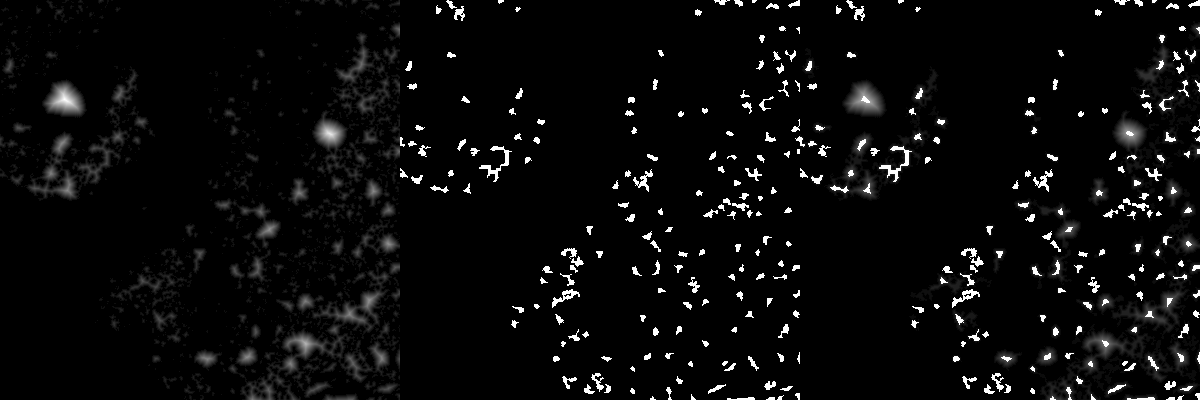

In [623]:
seg2[seg2 .< -23] .= -23
_dist2 = Gray.(-seg2 ./ maximum(abs.(seg2)))
Images.mosaicview(_dist, Gray.(mask2), _dist2, nrow=1)

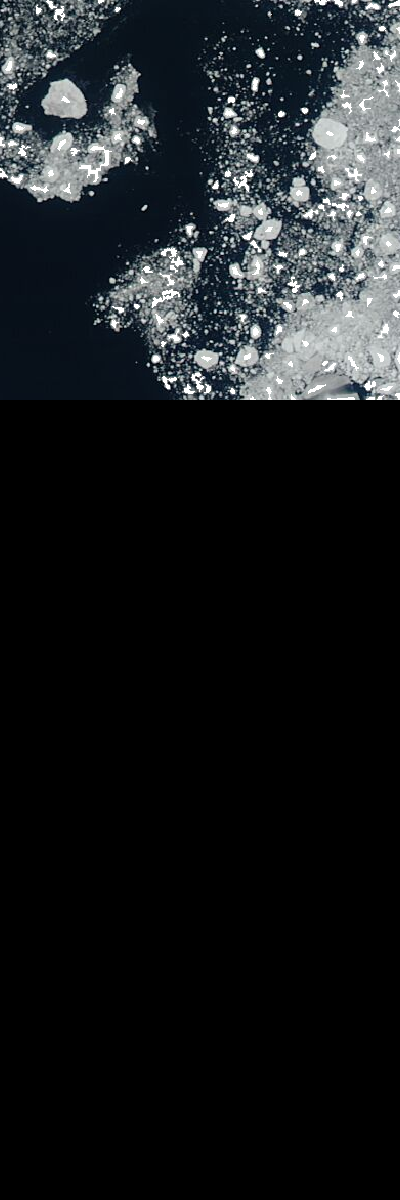

In [625]:
Images.mosaicview(tc_image + Gray.(mask2), nrow=3)

# Canny edge detection

In [626]:
using ImageEdgeDetection
img = copy(morphed_image)
img_edges₁ = detect_edges(img, Canny(spatial_scale = 1))
img_edges₂ = detect_edges(img, Canny(spatial_scale = 2))
img_edges₃ = detect_edges(img, Canny(spatial_scale = 3))
nothing

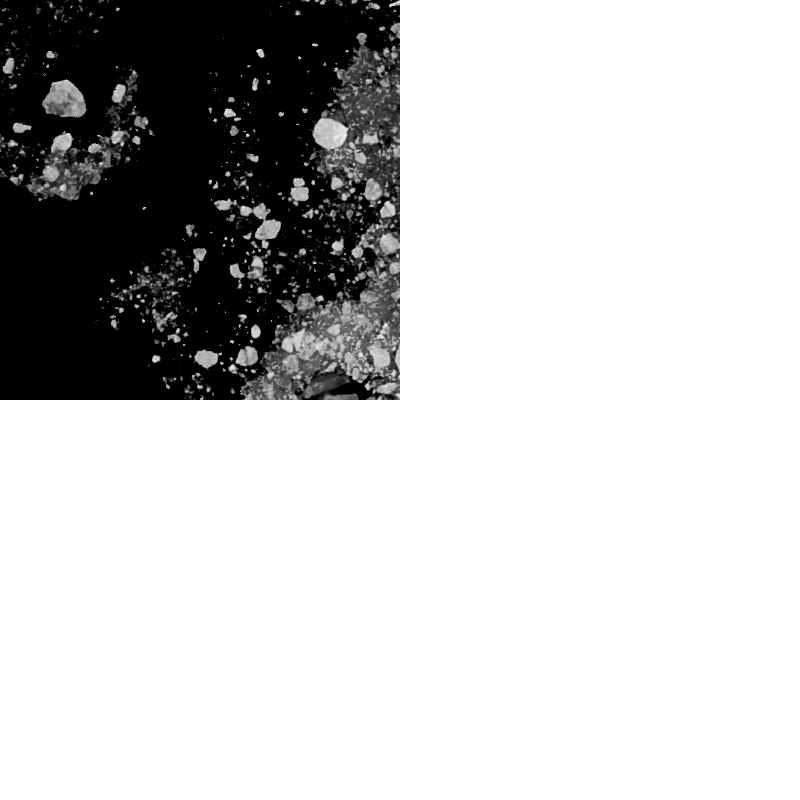

In [628]:
Images.mosaicview(img, img_edges₁, img_edges₂, img_edges₃; nrow = 2)

In [629]:
?IceFloeTracker.imbinarize

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `IceFloeTracker.imbinarize`


No documentation found for private symbol.

`IceFloeTracker.imbinarize` is a `Function`.

```
# 1 method for generic function "imbinarize" from IceFloeTracker:
 [1] imbinarize(img)
     @ ~/.julia/packages/IceFloeTracker/0WFKI/src/normalization.jl:182
```
